In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)


In [3]:
from initialization import DatasetInitializer, IdentityInitializer
from layers import DiscriminationModule, ClassificationModule
from loading import SequentialLoader
from metrics import Conncetedness, Consistency

metric1 = Conncetedness()
metric2 = Consistency()
loader = SequentialLoader(mnist_data, num_classes=10)


In [25]:
train_size = 5000
precisions = []
recalls = []
consistencies = []

for epoch in range(100, 600, 100):
    precision = []
    recall = []
    consistency = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(500, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(500, IdentityInitializer())
    
    for _ in tqdm(range(train_size//epoch), desc=str(epoch)):
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        metric1.update(module_c.connections, module_d.labels(10))
        metric2.update(module_d.labels(10))
        
        p, r = metric1.compute()
        c = metric2.compute()
        precision.append(p)
        recall.append(r)
        consistency.append(c)
    
    precisions.append(precision)
    recalls.append(recall)
    consistencies.append(consistency)
    metric1.reset()
    metric2.reset()

500: 100%|██████████| 10/10 [12:32<00:00, 75.27s/it]


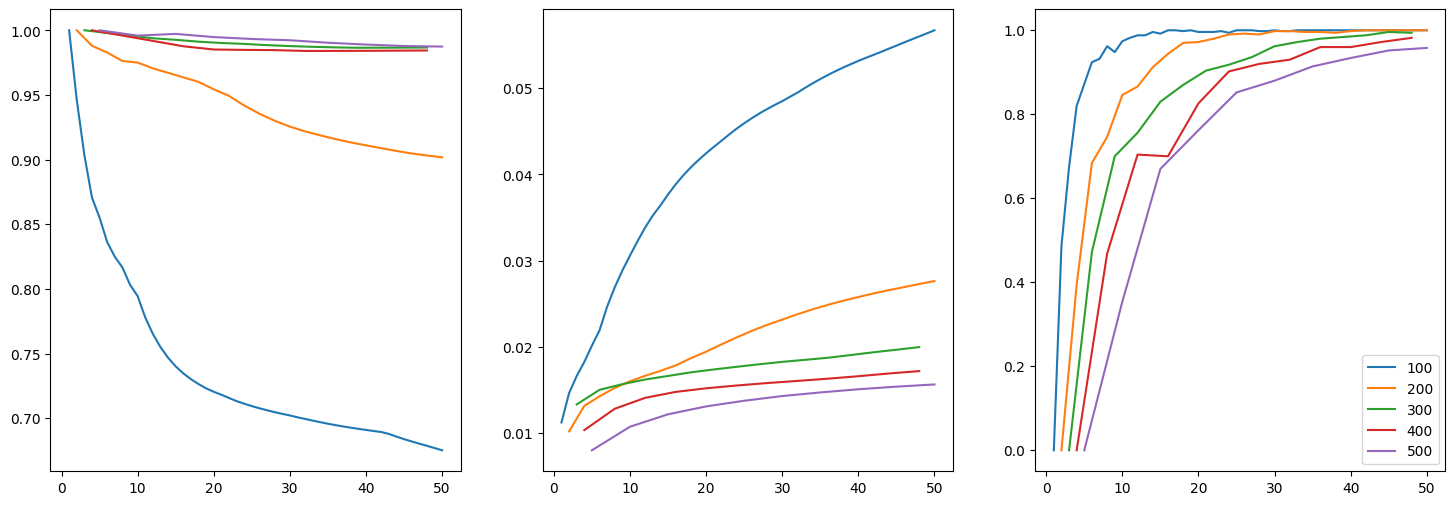

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(5):
    x = [*range(i+1, train_size//100+1, i+1)]
    ax[0].plot(x, precisions[i], label=str(100*(i+1)))
    ax[1].plot(x, recalls[i], label=str(100*(i+1)))
    ax[2].plot(x, consistencies[i], label=str(100*(i+1)))
plt.legend()

In [4]:
train_size = 10000
epoch = 200
precisions = []
recalls = []
beta = 1 - 1/epoch

module_d = DiscriminationModule(500, DatasetInitializer(mnist_data, num_classes=10), beta=beta)
module_c = ClassificationModule(500, IdentityInitializer())
module_c.pruning('on')
metric1.reset()
for eidx in tqdm(range(train_size//epoch)):
    for x in loader(epoch):
        y_ = module_d(x)
        module_c(y_)
    #module_c.pruning("on") if eidx > 25 else None
    module_d.organize()
    module_c.organize()
    metric1.update(module_c.connections.T, module_d.labels(10))
    p, r = metric1.compute()
    precisions.append(p)
    recalls.append(r)

100%|██████████| 50/50 [24:01<00:00, 28.83s/it]


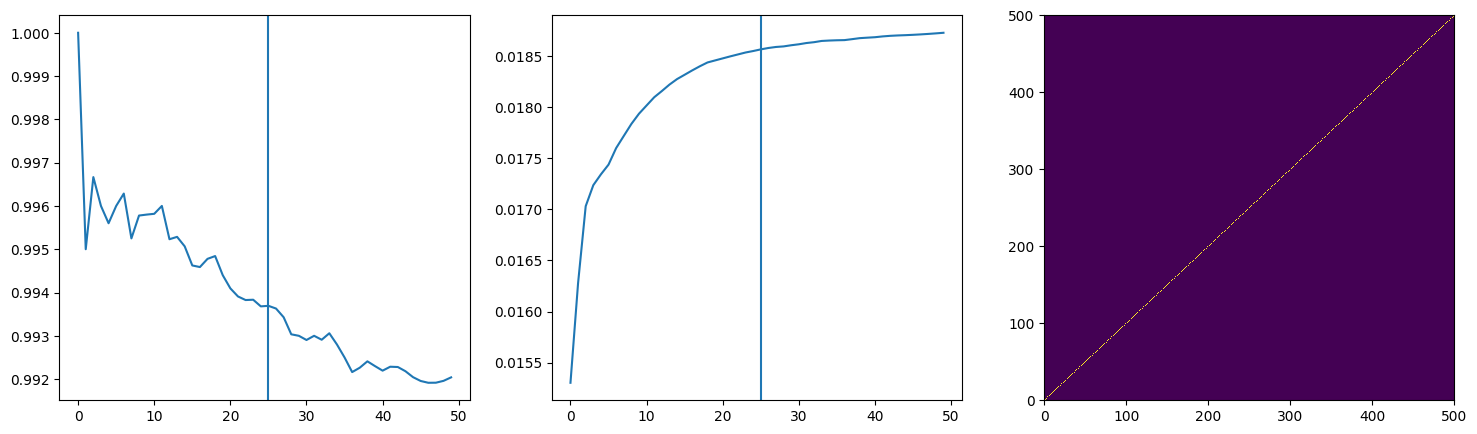

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(precisions)
ax[0].axvline(25)
ax[1].plot(recalls)
ax[1].axvline(25)
ax[2].pcolormesh(module_c.recurrent_weights)

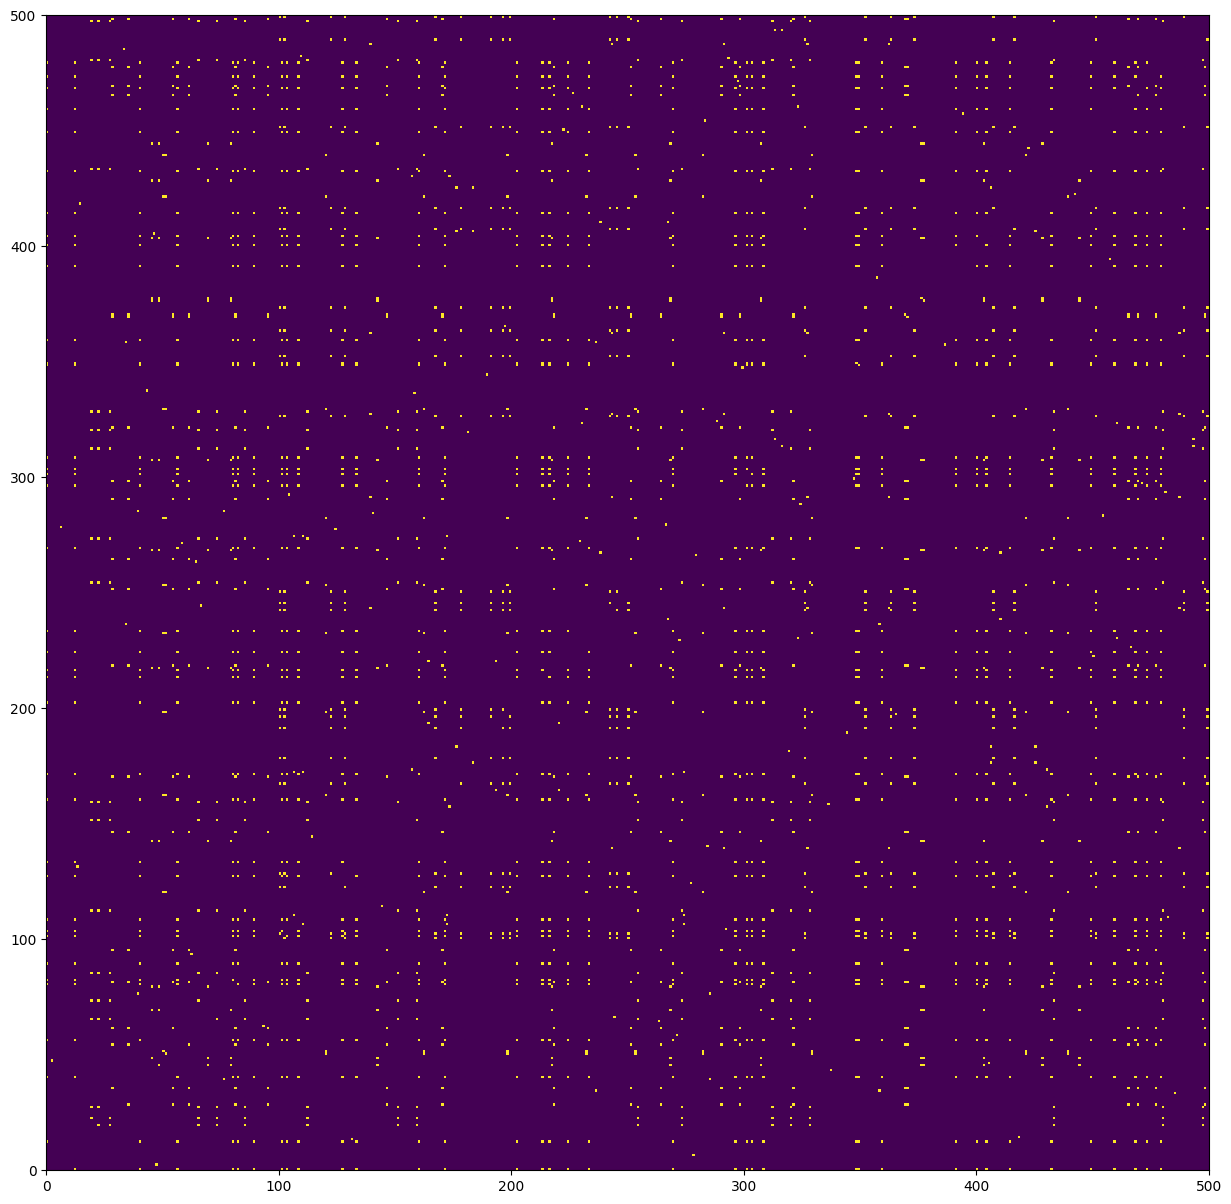

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.pcolormesh(module_c.recurrent_weights.fill_diagonal_(0.0))

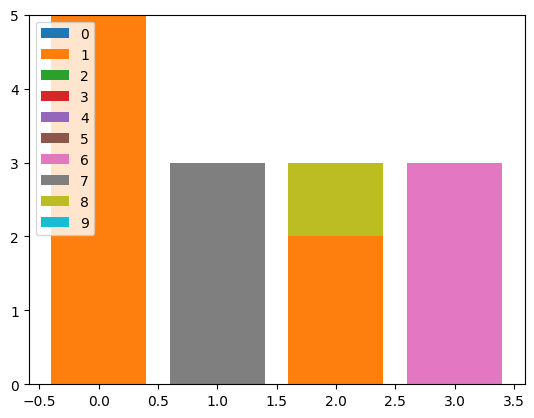

In [7]:
all_labels = module_d.labels(10)
label_counts = []
for row in module_c.connections.T:
    idxs = row.nonzero().flatten()
    if len(idxs) > 2:
        row_label_count = torch.empty(10, dtype=int)
        row_labels = all_labels[idxs]
        labels, counts = torch.unique(row_labels, return_counts=True)
        row_label_count[labels] = counts
        label_counts.append(row_label_count.tolist())
fig, ax = plt.subplots()
bottom = torch.zeros(len(label_counts))
for l in range(10):
    label_assignments = torch.tensor(label_counts).T[l]
    ax.bar(range(len(label_counts)), label_assignments.tolist(), label=str(l), bottom=bottom.tolist())
    bottom += label_assignments
plt.legend()

In [117]:
#graph = module_c.recurrent_weights.fill_diagonal_(0.0)
#graph_dict = {idx: row.nonzero().flatten().tolist() for idx, row in enumerate(graph)}

    



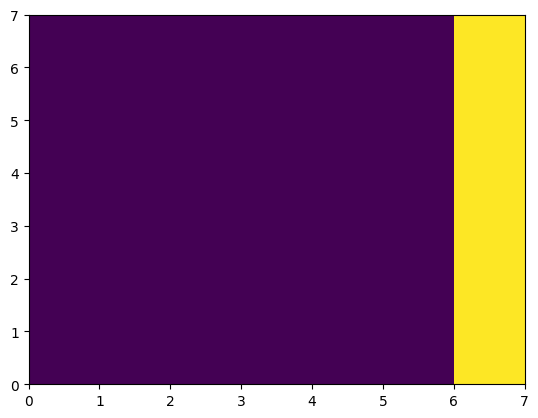

In [123]:
#graph_dict = {idx: row.nonzero().flatten().tolist() for idx, row in enumerate(module_c.recurrent_weights.fill_diagonal_(0.0))}
graph_dict = {0: [1, 3], 1: [0, 2], 2: [1], 3: [0, 4, 5, 6], 4: [3, 5], 5: [3, 4, 6], 6: [5, 3]}
pruned_connections = _prune(7, graph_dict)
plt.pcolormesh(pruned_connections)

#print(graph_dict)


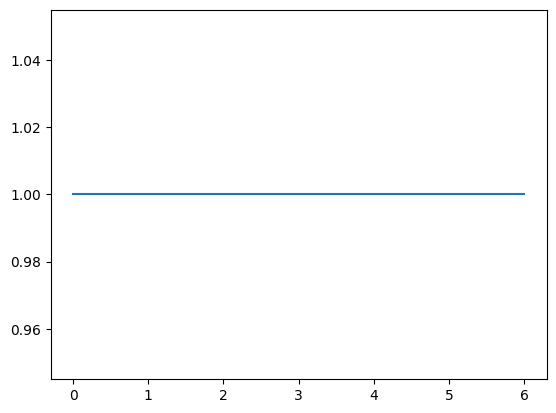

In [124]:

plt.plot(torch.sum(pruned_connections, dim=1))